# Sampling from multivariate lognormal distribution

In [1]:
import sandy

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import lognorm

sns.set_style("ticks")

Small simple covariance matrix

In [3]:
# 3 parameters with similar mean values (but not identical!)
parameters = ['A', 'B', 'C']
x1 = 4
x2 = 5
x3 = 6
mean = np.array([x1, x2, x3])

# relative standard deviations
s1 = 10 / 100
s2 = 3 / 100    # small stdev
s3 = 60 / 100   # large stdev

# correlations between parameters
c12 = 0.2
c13 = -0.4
c23 = 0.5

# building covariance matrix
cov = sandy.CategoryCov(
    pd.DataFrame(
        [
            [s1 * x1 * s1 * x1,         s1 * x1 * s2 * x2 * c12,   s1 * x1 * s3 * x3 * c13],
            [s2 * x2 * s1 * x1 * c12,   s2 * x2 * s2 * x2,         s2 * x2 * s3 * x3 * c23],
            [s3 * x3 * s1 * x1 * c13,   s3 * x3 * s2 * x2 * c23,   s3 * x3 * s3 * x3],
        ], index=parameters, columns=parameters,
    )
)

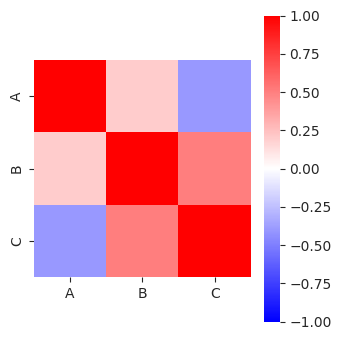

In [4]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=100)
ax.set_aspect("equal")
sns.heatmap(data=cov.get_corr().data, cmap='bwr', vmin=-1, vmax=1, ax=ax)
fig.tight_layout();

Let's convert mean vector and convariance matrix to relative terms.

In [5]:
cov_r = cov.corr2cov(1/mean)
cov_r.get_std()

A   1.00000e-01
B   3.00000e-02
C   6.00000e-01
Name: STD, dtype: float64

In [6]:
mean_r = mean / mean
mean_r

array([1., 1., 1.])

For parameters with medium/large standard deviations the left tail with a Normal distribution spans in the negative range.
For many nuclear data types, negative values do not have a physical meaning.

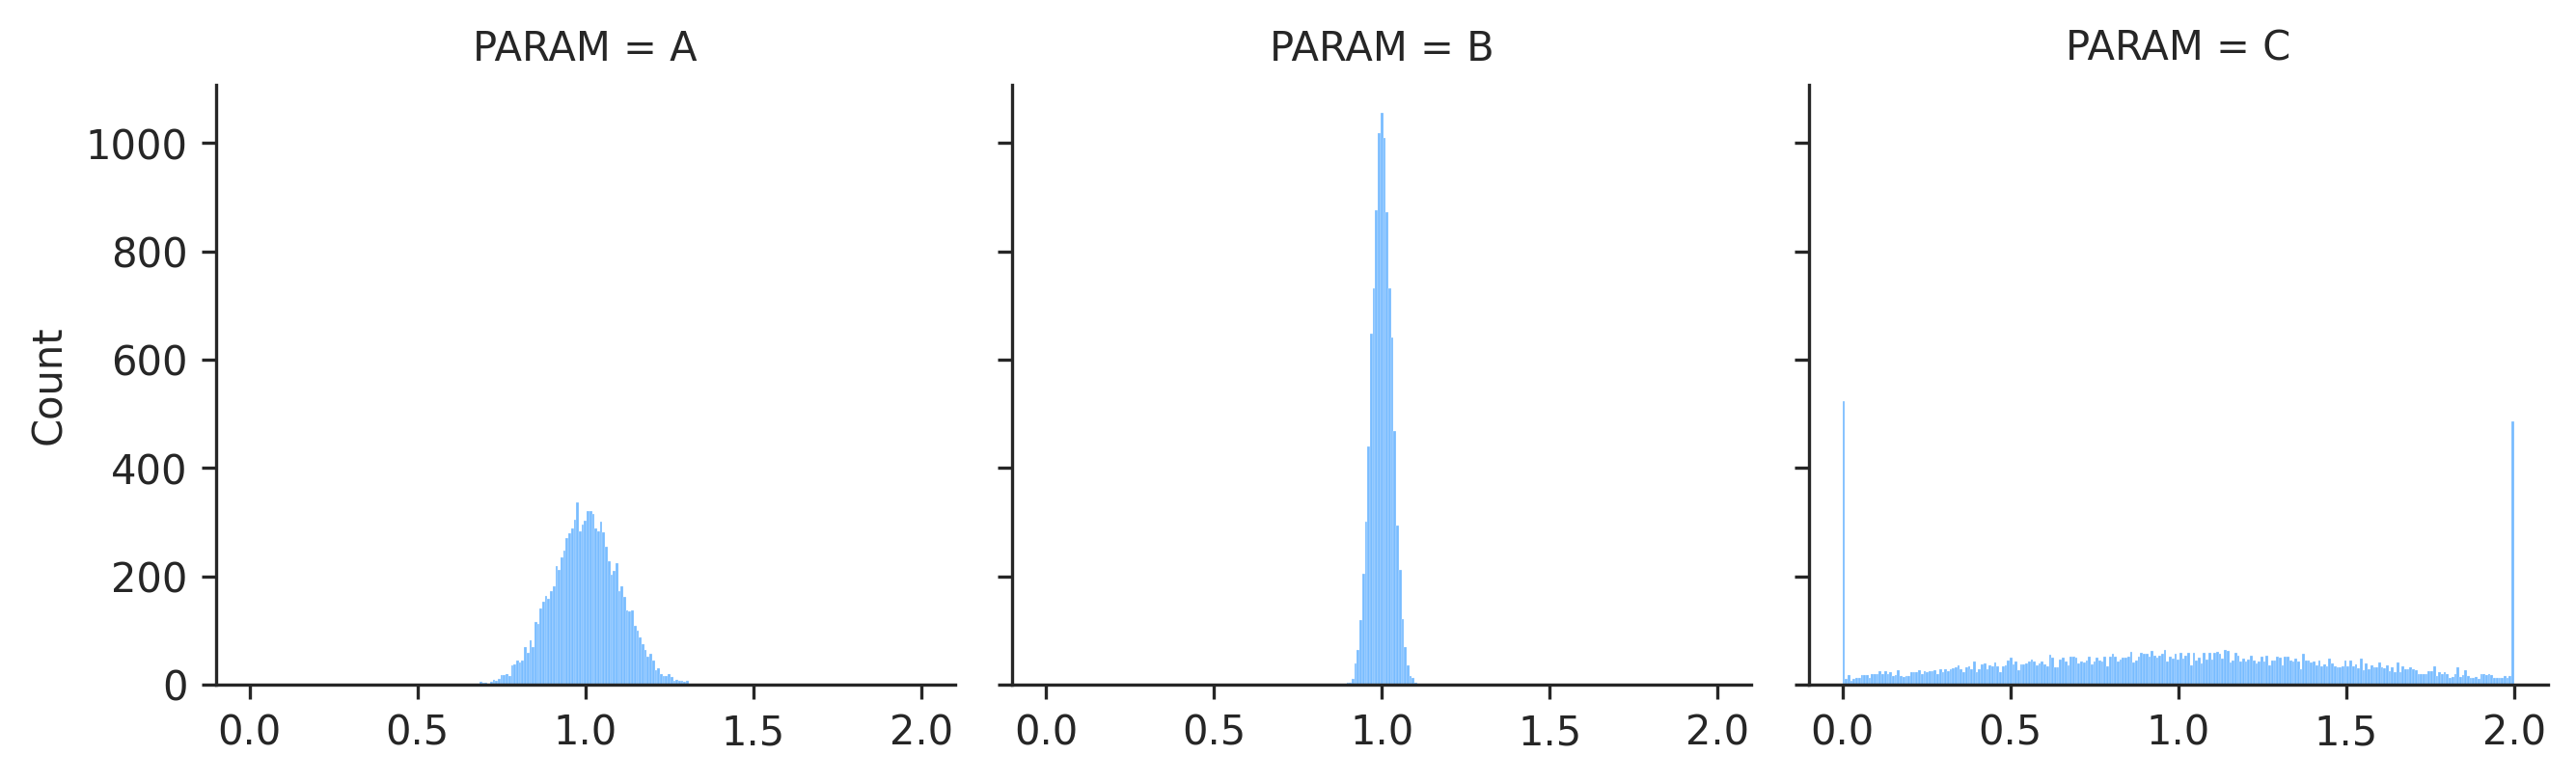

In [7]:
nsmp = 10000
data = cov_r.sampling(nsmp).data.T
data.index.name = "PARAM"
data.columns.name = "SMP"
data = data.stack().rename("VAL").reset_index()
g = sns.displot(data=data, x="VAL", col="PARAM",
                height=3, aspect=1, color="dodgerblue", alpha=.6
               )
g.fig.set_dpi(300)
g.axes[0, 0].set_xlabel(None)
g.axes[0, 1].set_xlabel(None)
g.axes[0, 2].set_xlabel(None)
plt.xlim(-0.1, 2.1);

This behavior can be avoided when sampling from a lognormal distribution. 

## Retrieve mean and covariance matrix of underlying normal distribution

Two-step approach to sample log-normally distributed variables with mean vector $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$:

- draw normally-distributed samples with underlying mean vector $\mathbf{\mu_N}$ and covariance matrix $\mathbf{\Sigma}_N$;
- apply an exponential operator to the normally-distributed samples.

$$
log\mathcal{N} \left( \mathbf{\mu}, \mathbf{\Sigma} \right) = exp \left( \mathcal{N} \left( \mathbf{\mu}_N, \mathbf{\Sigma}_N \right) \right)
$$

The underlying mean vector $\mathbf{\mu}_N$ and covariance matrix $\mathbf{\Sigma}_N$ can be defined starting from $\mathbf{\mu}$ and $\mathbf{\Sigma}$ as defined in https://doi.org/10.1016/j.nima.2013.06.025

$$
\mu_{N_i} = ln \left(\mu_i\right) - \frac{\sigma_i^2}{2}
$$

$$
\sigma_{N_i} = \sqrt{ln\left( 1 + \frac{\sigma_i^2}{\mu_i^2}\right)}
$$

$$
\Sigma_{N_{i,j}} = ln\left( 1 + \frac{\Sigma_{i,j}^2}{\mu_i\mu_j}\right)
$$

If the mean vector is $\mathbf{\mu}=\mathbf{1}$, the equations above simplify to

$$
\mu_{N_i} =  - \frac{\sigma_i^2}{2}
$$

$$
\sigma_{N_i} = \sqrt{ln\left( 1 + \sigma_i^2 \right)}
$$

$$
\Sigma_{N_{i,j}} = ln\left( 1 + \Sigma_{i,j}\right)
$$

In [8]:
mean_N = - np.diag(cov_r.data) / 2
cov_N = np.log(cov_r.data + 1)

## Sampling from normal distribution

In [9]:
nsmp = 10000
y = np.random.randn(3, nsmp)
L = np.linalg.cholesky(cov_N)
smp_N = L.dot(y) + mean_N.reshape(-1, 1)

In [10]:
smp_LogN = np.exp(smp_N)

### Sample analysis

In [11]:
data = pd.DataFrame(smp_LogN, index=parameters)
data.index.name = "PARAM"
data.columns.name = "SMP"
data = data.stack().rename("VAL").reset_index()

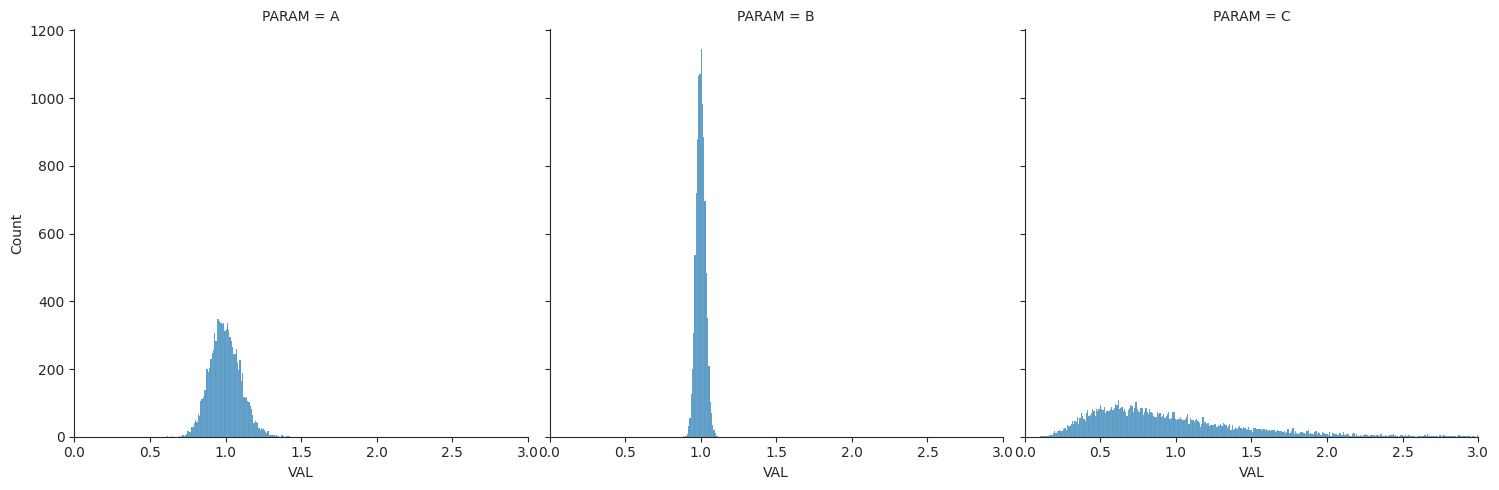

In [12]:
g = sns.displot(data=data, x="VAL", col="PARAM")
plt.xlim(0, 3);

In [13]:
data.groupby("PARAM").VAL.describe()

,count,mean,std,min,25%,50%,75%,max
PARAM,,,,,,,,
A,1.00000e+04,9.98041e-01,1.00510e-01,6.19075e-01,9.29411e-01,9.92244e-01,1.06411e+00,1.42012e+00
B,1.00000e+04,9.99680e-01,2.95664e-02,8.85867e-01,9.79601e-01,9.99536e-01,1.01968e+00,1.10939e+00
C,1.00000e+04,9.72115e-01,5.64719e-01,1.02395e-01,5.78611e-01,8.34666e-01,1.21546e+00,5.75380e+00


The shape, mean and standard deviations of the lognormal samples look correct!

In [14]:
data.pivot_table(index="SMP", columns="PARAM", values="VAL").corr()

PARAM,A,B,C
PARAM,,,
A,1.00000e+00,2.04145e-01,-4.06376e-01
B,2.04145e-01,1.00000e+00,4.89982e-01
C,-4.06376e-01,4.89982e-01,1.00000e+00


Also correlations converge to what was is expected.

In [15]:
(data.VAL < 0).any()

False

...and all values the lognormal distribution are obviously positive!

If we multiply the relative samples by the original mean we go back to absolute values.

In [16]:
foo = lambda row: row.VAL * mean[0] if row.PARAM == "A" else row.VAL * mean[1] if row.PARAM == "B" else row.VAL * mean[2]
data["VAL_ABS"]  = data.apply(foo, axis=1)

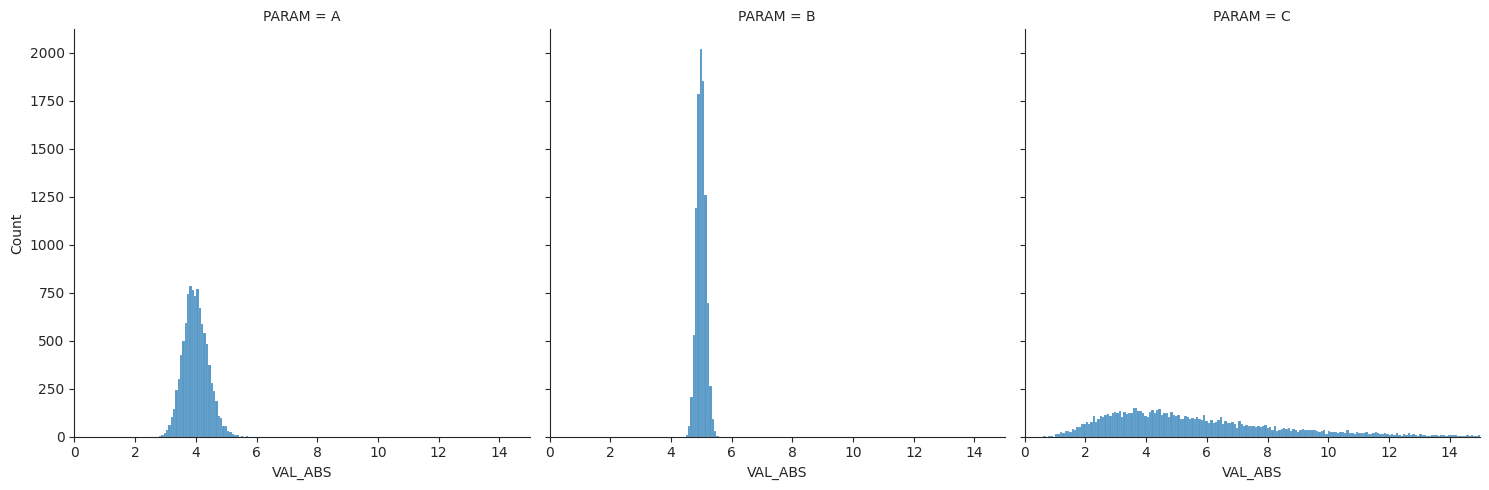

In [17]:
g = sns.displot(data=data, x="VAL_ABS", col="PARAM")
plt.xlim(0, 15);

In [18]:
data.groupby("PARAM").VAL_ABS.describe()

,count,mean,std,min,25%,50%,75%,max
PARAM,,,,,,,,
A,1.00000e+04,3.99217e+00,4.02039e-01,2.47630e+00,3.71764e+00,3.96898e+00,4.25643e+00,5.68047e+00
B,1.00000e+04,4.99840e+00,1.47832e-01,4.42934e+00,4.89800e+00,4.99768e+00,5.09842e+00,5.54696e+00
C,1.00000e+04,5.83269e+00,3.38832e+00,6.14373e-01,3.47167e+00,5.00800e+00,7.29273e+00,3.45228e+01


Relative standard deviation.

In [19]:
data.pivot_table(index="SMP", columns="PARAM", values="VAL_ABS").std() / data.pivot_table(index="SMP", columns="PARAM", values="VAL_ABS").mean()

PARAM
A   1.00707e-01
B   2.95759e-02
C   5.80918e-01
dtype: float64

Correlations.

In [20]:
data.pivot_table(index="SMP", columns="PARAM", values="VAL_ABS").corr()

PARAM,A,B,C
PARAM,,,
A,1.00000e+00,2.04145e-01,-4.06376e-01
B,2.04145e-01,1.00000e+00,4.89982e-01
C,-4.06376e-01,4.89982e-01,1.00000e+00


## Plot sample convergence

For these plots we use the functions and methods already implemented in `sandy`.

In [21]:
nsmp = list(range(10, 1000, 10)) + list(range(1000, 5001, 100))

In [22]:
lognorm = {n: cov_r.sampling(n, pdf="lognormal").data.std() for n in nsmp}
norm = {n: cov_r.sampling(n, pdf="normal").data.std() for n in nsmp}

In [23]:
df = pd.DataFrame(norm).T
df.index.name = "NSMP"
df.columns.name = "PARAM"
dfnorm = df.stack().rename("STD").reset_index().assign(PDF="normal")

df = pd.DataFrame(lognorm).T
df.index.name = "NSMP"
df.columns.name = "PARAM"
dflognorm = df.stack().rename("STD").reset_index().assign(PDF="lognormal")

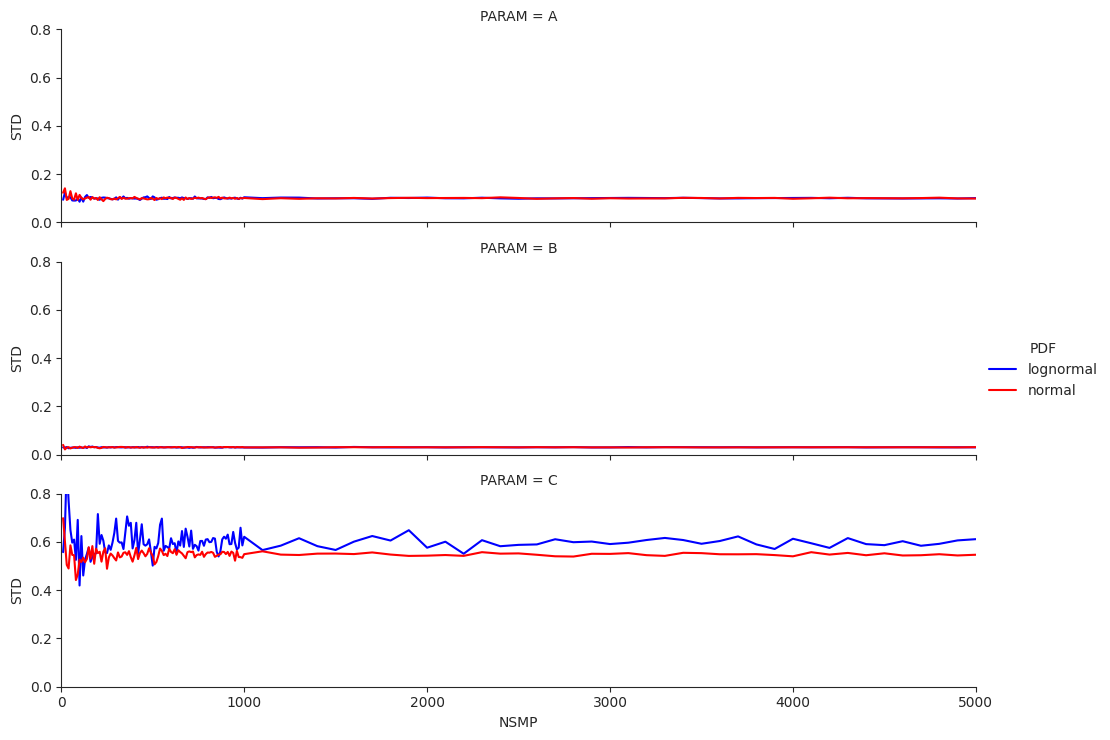

In [24]:
df = pd.concat([dflognorm, dfnorm], ignore_index=True)

g = sns.relplot(
    data=df, x="NSMP", y="STD", row="PARAM",
    hue="PDF", kind="line", palette=["b", "r"],
    height=2.5, aspect=4,
)
g.figure.set_dpi(100)
plt.xlim(0, 5000)
plt.ylim(0, 0.8);

## Plot mean convergence

In [25]:
lognorm = {n: cov_r.sampling(n, pdf="lognormal").data.mean() for n in nsmp}
norm = {n: cov_r.sampling(n, pdf="normal").data.mean() for n in nsmp}

In [26]:
df = pd.DataFrame(norm).T
df.index.name = "NSMP"
df.columns.name = "PARAM"
dfnorm = df.stack().rename("MEAN").reset_index().assign(PDF="normal")

df = pd.DataFrame(lognorm).T
df.index.name = "NSMP"
df.columns.name = "PARAM"
dflognorm = df.stack().rename("MEAN").reset_index().assign(PDF="lognormal")

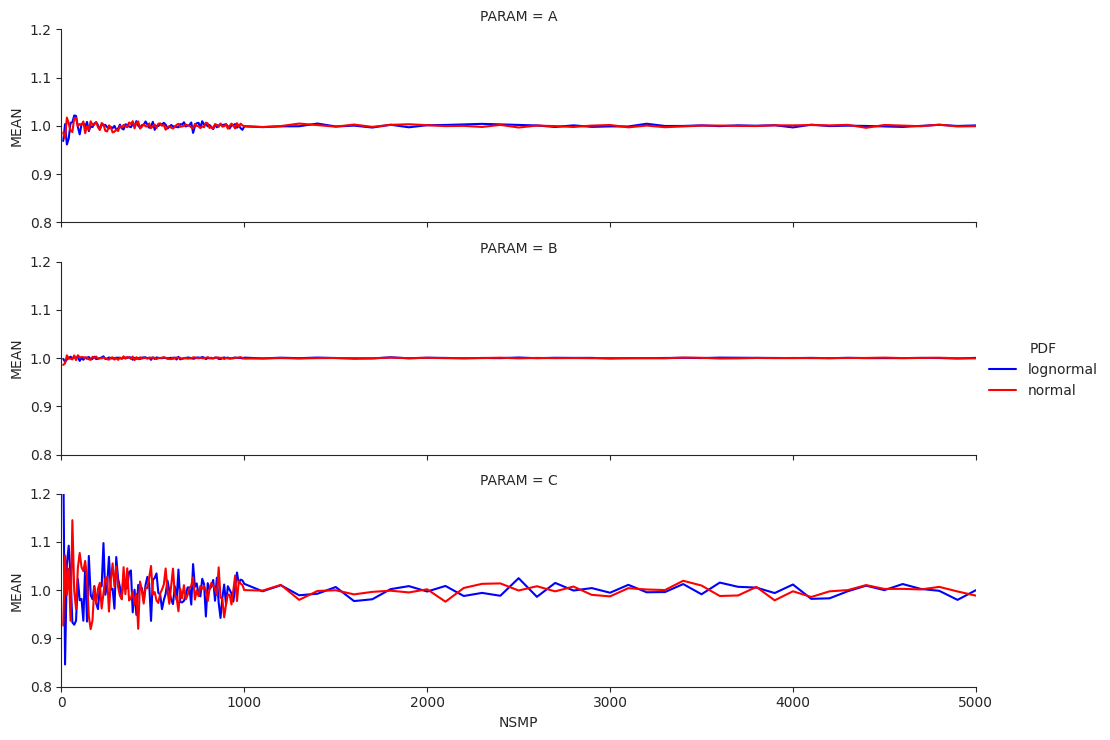

In [27]:
df = pd.concat([dflognorm, dfnorm], ignore_index=True)

g = sns.relplot(
    data=df, x="NSMP", y="MEAN", row="PARAM",
    hue="PDF", kind="line", palette=["b", "r"],
    height=2.5, aspect=4,
)
g.figure.set_dpi(100)
plt.xlim(0, 5000)
plt.ylim(0.8, 1.2);

## Plot correlation convergence

In [28]:
lognorm = {n: cov_r.sampling(n, pdf="lognormal").data.corr().stack().loc[[("A", "B"), ("A", "C"), ("B", "C")]] for n in nsmp}
norm = {n: cov_r.sampling(n, pdf="normal").data.corr().stack().loc[[("A", "B"), ("A", "C"), ("B", "C")]] for n in nsmp}

In [29]:
df = pd.DataFrame(norm).T
df.index.name = "NSMP"
df.columns.names = ("PARAM_1", "PARAM_2")
dfnorm = df.unstack().rename("CORR").reset_index().assign(PDF="normal")

df = pd.DataFrame(lognorm).T
df.index.name = "NSMP"
df.columns.names = ("PARAM_1", "PARAM_2")
dflognorm = df.unstack().rename("CORR").reset_index().assign(PDF="lognormal")

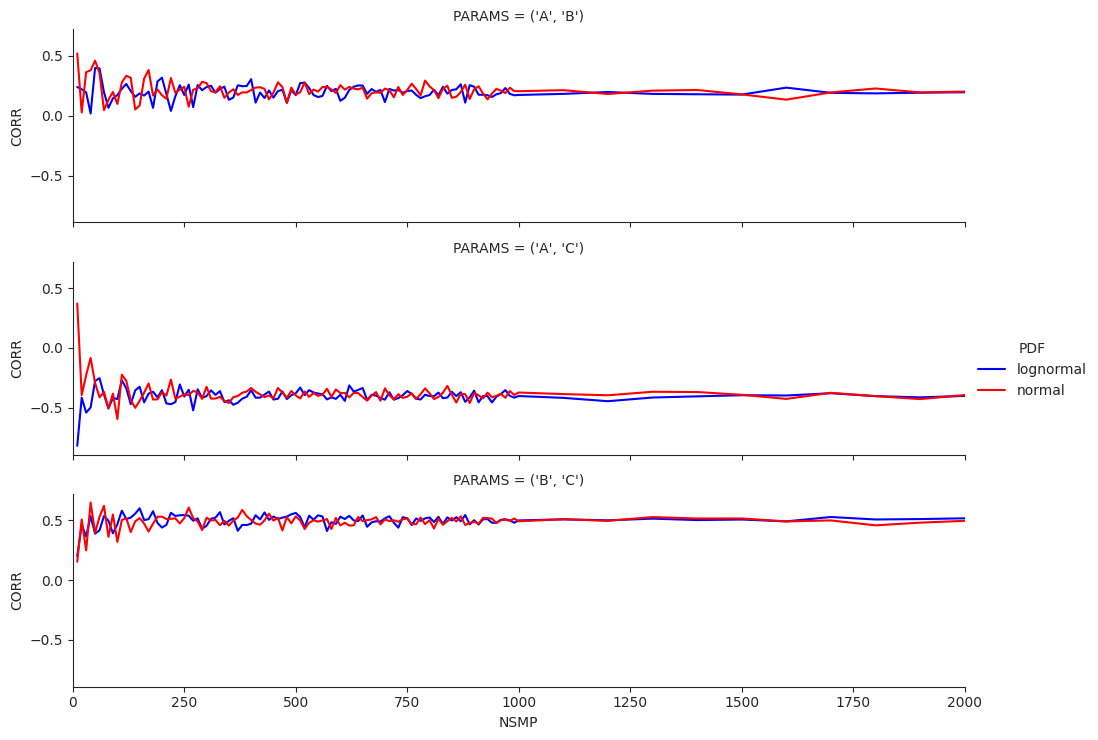

In [30]:
df = pd.concat([dflognorm, dfnorm], ignore_index=True)
df["PARAMS"] = df.apply(lambda row: (row.PARAM_1, row.PARAM_2), axis=1)

g = sns.relplot(
    data=df, x="NSMP", y="CORR", row="PARAMS",
    hue="PDF", kind="line", palette=["b", "r"],
    height=2.5, aspect=4,
)
g.figure.set_dpi(100)
plt.xlim(0, 2000);

## Putting it all together

In [31]:
nsmp = 10000

data_n = cov_r.sampling(nsmp, pdf="normal").data.T
data_n.index.name = "PARAM"
data_n.columns.name = "SMP"
data_n = data_n.stack().rename("VAL").reset_index().assign(PDF="normal")

data_ln = cov_r.sampling(nsmp, pdf="lognormal").data.T
data_ln.index.name = "PARAM"
data_ln.columns.name = "SMP"
data_ln = data_ln.stack().rename("VAL").reset_index().assign(PDF="lognormal")

data_u = cov_r.sampling(nsmp, pdf="uniform").data.T
data_u.index.name = "PARAM"
data_u.columns.name = "SMP"
data_u = data_u.stack().rename("VAL").reset_index().assign(PDF="uniform")

(-0.1, 2.1)

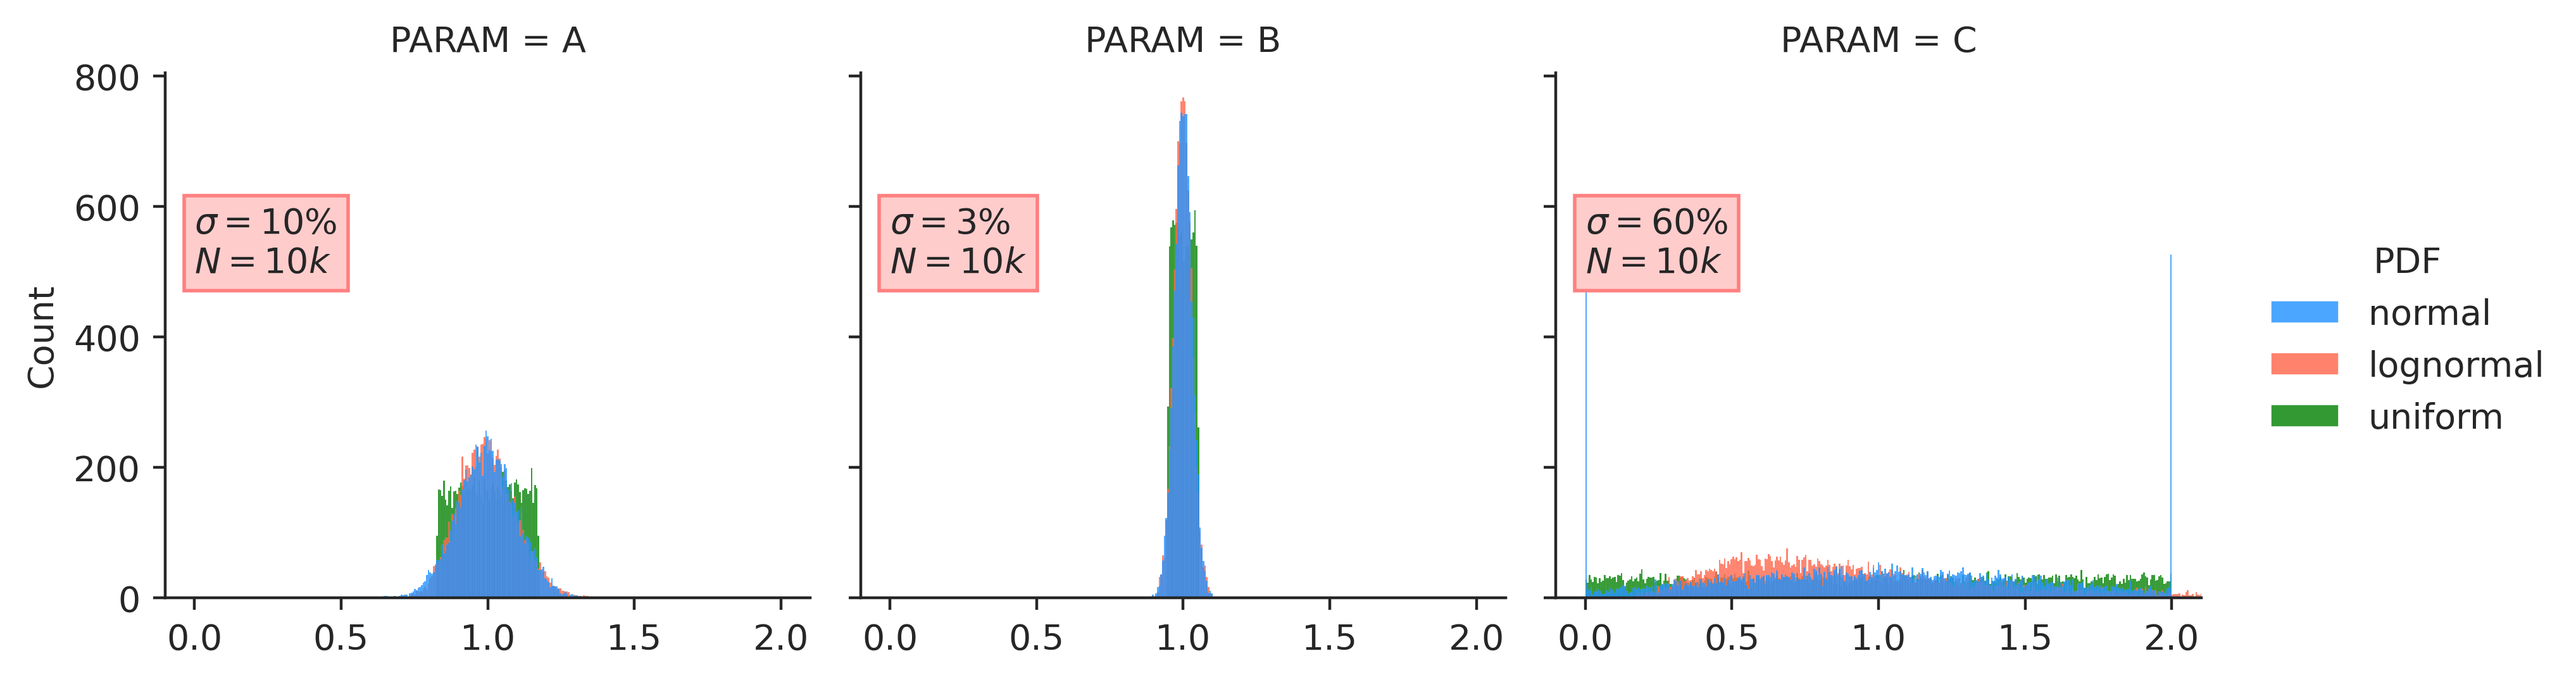

In [32]:
g = sns.displot(data=pd.concat([data_n, data_ln, data_u], ignore_index=True),
                x="VAL", col="PARAM", hue="PDF",
                height=3, aspect=1, alpha=.8, palette=["dodgerblue", "tomato", "green"],
               )
g.fig.set_dpi(400)
g.axes[0, 0].set_xlabel(None)
g.axes[0, 1].set_xlabel(None)
g.axes[0, 2].set_xlabel(None)
g.axes[0, 0].text(0, 600, "$\\sigma=10 \%$\n$N=10k$", size=10, va="top",
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
g.axes[0, 1].text(0, 600, "$\\sigma=3 \%$\n$N=10k$", size=10, va="top",
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
g.axes[0, 2].text(0, 600, "$\\sigma=60 \%$\n$N=10k$", size=10, va="top",
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
plt.xlim(-0.1, 2.1)